# Домашнее задание №2

ФИО: Куканова Абина

In [1]:
!pip install -U kaleido
!pip install datasets
!pip install evaluate
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.1 MB/s eta 0:00:00
  Pre

In [2]:
# Importing Libraries

# Data Handling
import pandas as pd
import numpy as np
from datasets import load_dataset, Dataset

# Data Visualization
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

#Transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import torch
import evaluate

In [3]:
#Import packages to manipulate and transform the text
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Data Overview

In [4]:
ds = load_dataset("abisee/cnn_dailymail", "3.0.0")
ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [5]:
train_df = ds['train'].to_pandas()
val_df = ds['validation'].to_pandas()
test_df = ds['test'].to_pandas()

train_df = train_df.drop(columns='id')
val_df = val_df.drop(columns='id')
test_df = test_df.drop(columns='id')

train_df['token_count'] = train_df['article'].apply(lambda x: len(str(x).split()))
val_df['token_count'] = val_df['article'].apply(lambda x: len(str(x).split()))
test_df['token_count'] = test_df['article'].apply(lambda x: len(str(x).split()))

In [6]:
# Оставим только строчки длиной от 1024 до 2048
train_df = train_df.query('1024 < token_count < 2048')
val_df = val_df.query('1024 < token_count < 2048')
test_df = test_df.query('1024 < token_count < 2048')

In [7]:
RANDOM_STATE = 42
N = 10000

train_df = train_df.sample(n=N, random_state=RANDOM_STATE)

In [8]:
display(train_df.shape)
display(val_df.shape)
display(test_df.shape)

(10000, 3)

(2092, 3)

(1875, 3)

## Exploratory Data Analysis

In [9]:
def get_histogram_boxplot(df, name):
    fig = make_subplots(rows=1, cols=2,
                    subplot_titles=["Box Plot", "Histogram"], horizontal_spacing=0.2,
                   specs=[[{"type": "box"}, {"type": "histogram"}]])

    fig.add_trace(
        go.Box(y=df['token_count'],
              name='Box Plot'),
        row=1, col=1
    )

    fig.add_trace(
        go.Histogram(x=df['token_count'],
                    name='Histogram'),
        row=1, col=2
    )

    fig.update_layout(
        title=f'<b>{name} Word Count</b>',
        xaxis_title='Words',
        yaxis_title='Frequency',
        plot_bgcolor='black',
        paper_bgcolor='black',
        font_color='white',
        height=600, width=1000
    )

    fig.update_yaxes(title_text="Count", row=1, col=1)
    fig.update_yaxes(title_text="Frequency", row=1, col=2)
    fig.update_traces(marker_color='magenta', row=1, col=1)
    fig.update_traces(marker_color='#64C9E1', opacity=0.8, row=1, col=2)

    fig.show(renderer="svg")

In [10]:
def get_info(df):
    print(f"\n{type(df).__name__} shape: {df.shape}")
    print(f"\n{df.shape[0]:,.0f} rows")
    print(f"\n{df.shape[1]:,.0f} columns")
    print(f'\nMissing Data: \n{df.isnull().sum()}')
    print(f'\nDuplicates: {df.duplicated().sum()}')
    print(f'\nData Types: \n{df.dtypes}')

In [11]:
print('Train Dataset')
get_info(train_df)

Train Dataset

DataFrame shape: (10000, 3)

10,000 rows

3 columns

Missing Data: 
article        0
highlights     0
token_count    0
dtype: int64

Duplicates: 26

Data Types: 
article        object
highlights     object
token_count     int64
dtype: object


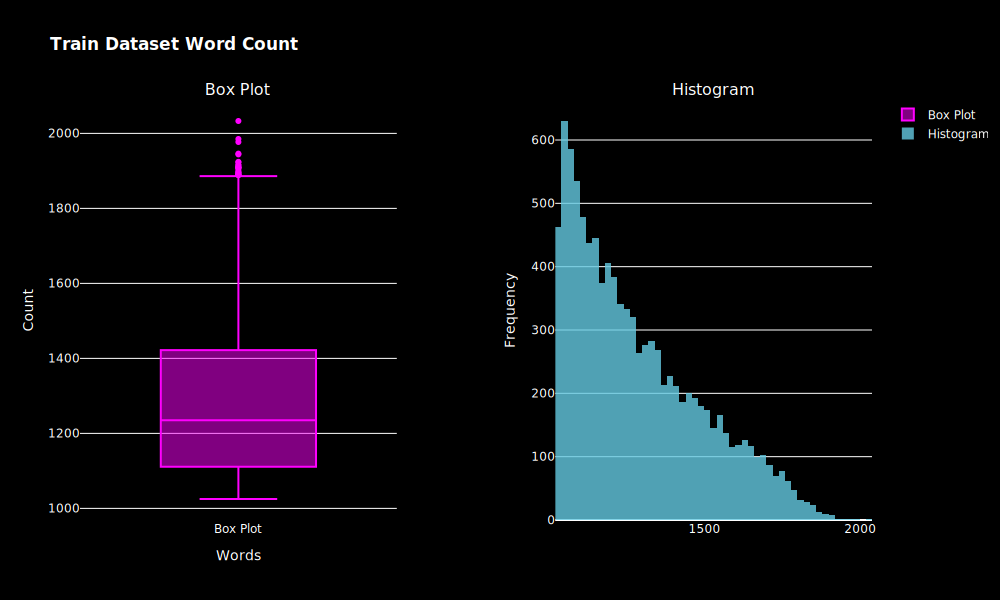

In [12]:
get_histogram_boxplot(train_df, 'Train Dataset')

In [13]:
train_df['token_count'].describe()

,token_count
count,10000.000000
mean,1285.422300
std,206.867742
min,1025.000000
25%,1111.000000
50%,1235.000000
75%,1422.000000
max,2033.000000


In [14]:
print('Validation Dataset')
get_info(val_df)

Validation Dataset

DataFrame shape: (2092, 3)

2,092 rows

3 columns

Missing Data: 
article        0
highlights     0
token_count    0
dtype: int64

Duplicates: 0

Data Types: 
article        object
highlights     object
token_count     int64
dtype: object


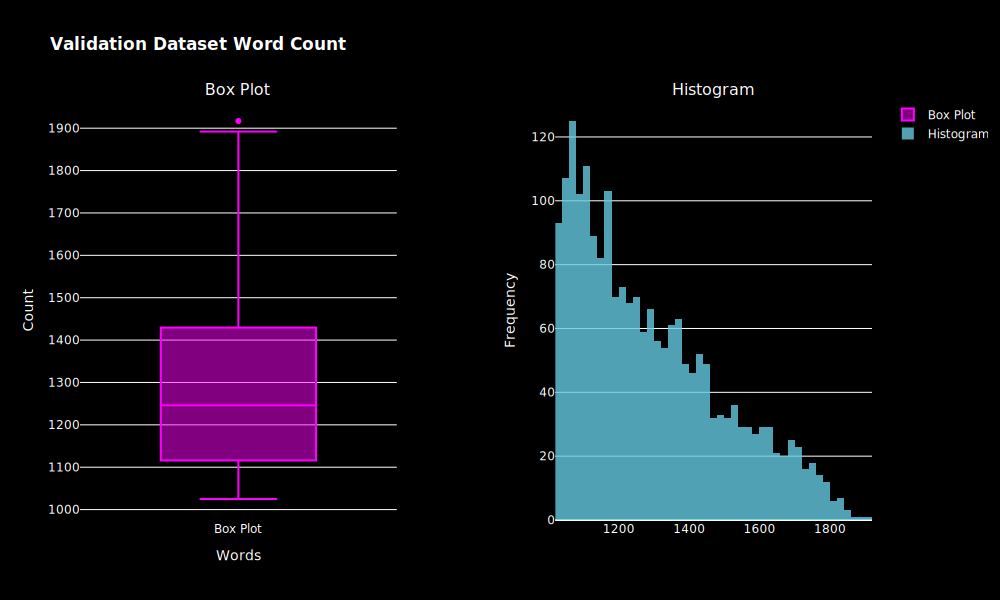

In [15]:
get_histogram_boxplot(val_df, 'Validation Dataset')

In [16]:
val_df['token_count'].describe()

,token_count
count,2092.000000
mean,1291.886233
std,205.777125
min,1025.000000
25%,1116.000000
50%,1246.000000
75%,1429.250000
max,1917.000000


In [17]:
print('Test Dataset')
get_info(test_df)

Test Dataset

DataFrame shape: (1875, 3)

1,875 rows

3 columns

Missing Data: 
article        0
highlights     0
token_count    0
dtype: int64

Duplicates: 1

Data Types: 
article        object
highlights     object
token_count     int64
dtype: object


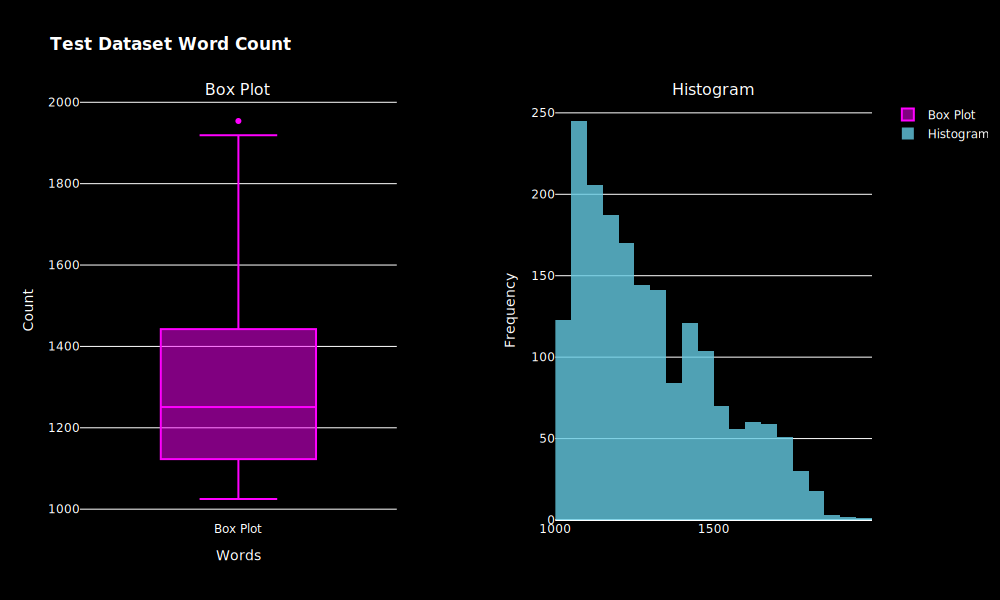

In [18]:
get_histogram_boxplot(test_df, 'Test Dataset')

In [19]:
test_df['token_count'].describe()

,token_count
count,1875.000000
mean,1299.494400
std,209.911671
min,1025.000000
25%,1123.000000
50%,1251.000000
75%,1442.000000
max,1954.000000


- Оставили только строчки длиной от 1024 до 2048
- В тренировочном датасете статьи в среднем длиной 1285 токенов;
- Графики распределения токенов в статьях смещены влево

## Data Preprocessing

In [9]:
tokenizer = AutoTokenizer.from_pretrained("google/long-t5-tglobal-base")
model = AutoModelForSeq2SeqLM.from_pretrained("google/long-t5-tglobal-base")

config.json:   0%|          | 0.00/851 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [10]:
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)
val_ds = Dataset.from_pandas(val_df)
print(train_ds)
print(test_ds)
print(val_ds)

Dataset({
    features: ['article', 'highlights', 'token_count', '__index_level_0__'],
    num_rows: 10000
})
Dataset({
    features: ['article', 'highlights', 'token_count', '__index_level_0__'],
    num_rows: 1875
})
Dataset({
    features: ['article', 'highlights', 'token_count', '__index_level_0__'],
    num_rows: 2092
})


In [11]:
if torch.cuda.is_available():
    print("GPU is available. \nUsing GPU")
    device = torch.device('cuda')
else:
    print("GPU is not available. \nUsing CPU")
    device = torch.device('cpu')

GPU is available. 
Using GPU


In [12]:
max_input_length = 2048
max_target_length = 200
metric = evaluate.load("rouge")
def preprocess_function(examples):
    inputs = [doc for doc in examples["article"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["highlights"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [13]:
# Applying preprocess_function to the datasets
tokenized_train = train_ds.map(preprocess_function, batched=True,
                               remove_columns=['article', 'highlights', 'token_count', '__index_level_0__']) # Removing features

tokenized_test = test_ds.map(preprocess_function, batched=True,
                               remove_columns=['article', 'highlights', 'token_count', '__index_level_0__']) # Removing features

tokenized_val = val_ds.map(preprocess_function, batched=True,
                               remove_columns=['article', 'highlights', 'token_count', '__index_level_0__']) # Removing features

# Printing results
print('\n' * 3)
print('Preprocessed Training Dataset:\n')
print(tokenized_train)
print('\n' * 2)
print('Preprocessed Test Dataset:\n')
print(tokenized_test)
print('\n' * 2)
print('Preprocessed Validation Dataset:\n')
print(tokenized_val)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1875 [00:00<?, ? examples/s]

Map:   0%|          | 0/2092 [00:00<?, ? examples/s]





Preprocessed Training Dataset:

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 10000
})



Preprocessed Test Dataset:

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1875
})



Preprocessed Validation Dataset:

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 2092
})


Я обучала модель в гугл коллабе, поэтому самой главной задачей было, чтобы обучение поместилось в памяти гпу.

- уменьшили размер батча до 2
- увеличили `gradient_accumulation_steps` для компенсации уменьшения размера батча
- добавили `gradient_checkpointing`, которая обменивает потребление памяти на вычислительное время

In [14]:
# Instantiating Data Collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    learning_rate=1e-4,
    fp16=True,
    gradient_checkpointing=True
)


model.gradient_checkpointing_enable()

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
500,9327435314865636.000000
1000,5468576111883452.000000
1500,12761006040154.111328


In [49]:
tokenizer.save_pretrained("./results")

('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/spiece.model',
 './results/added_tokens.json',
 './results/tokenizer.json')

In [75]:
eval_results = trainer.evaluate()

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.35 GiB. GPU 0 has a total capacity of 14.75 GiB of which 2.10 GiB is free. Process 7301 has 12.64 GiB memory in use. Of the allocated memory 8.58 GiB is allocated by PyTorch, and 3.93 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Возьмем 10 случайных строчек из тестовых данных, загрузим модель и токенизатор, чтобы сделать инференс.

In [51]:
random_indices = np.random.choice(len(test_ds), size=10, replace=False)
test_subset = test_ds.select(random_indices)

In [61]:
new_articles = []
for example in test_subset['article']:
  new_articles.append(example)

In [60]:
model = AutoModelForSeq2SeqLM.from_pretrained("/content/results")
tokenizer = AutoTokenizer.from_pretrained("/content/results")

In [57]:
def inference_preprocess_function(examples):
    inputs = [doc for doc in examples["article"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding=True, return_tensors="pt")
    return model_inputs

new_dataset = {"article": new_articles}
tokenized_new_data = inference_preprocess_function(new_dataset)

In [62]:
from transformers import pipeline

summarizer = pipeline("summarization", model=model, tokenizer=tokenizer)
new_summaries = summarizer(new_articles, max_length=2048, min_length=30, do_sample=False)
print("\nРезультаты pipeline:")
for summary in new_summaries:
  print(summary["summary_text"])

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Your max_length is set to 2048, but your input_length is only 1605. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=802)
Your max_length is set to 2048, but your input_length is only 1567. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=783)
Your max_length is set to 2048, but your input_length is only 1656. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=828)
Your max_length is set to 2048, but your input_length is only 1606. Since this is a summarizati


Результаты pipeline:
A prison source told The Sun: 'He was bitter and twisted and did not want people to have the satisfaction and relief of knowing he was dead.' In 2000 he confessed his part in the deaths of Gary Hanlon, 12, and Susan Blatchford, 11, thirty years earlier, while serving a life sentence for strangling an eight-year-old girl. I just don't want him to be able to hurt anyone else's children' Crimes: In 2000 confessed his part in the deaths of friends Gary Hanlon, 12, and Susan Blatchford, 11, who he murdered and dumped on the edge of Epping Forest . In 2000 three decades of anguish for the mothers of Susan Blatchford, 11, and Gary Hanlon, 12, came to an emotional close as paedophile Ronald Jebson, who was already in jail for another murder, finally admitted raping and strangling them.
Four years after the 2011 revolution that saw Colonel Gaddafi's hold on Libya crumbled, the once feared Bab al-Aziziya compound, situated in the capital city of Tripoli, resembles a wastela

In [82]:
df = pd.DataFrame(new_summaries)
df['article'] = new_articles
df

,summary_text,article
0,A prison source told The Sun: 'He was bitter a...,"Murderer: Ronald Jebson, who was responsible f..."
1,Four years after the 2011 revolution that saw ...,They were once sprawling palace compounds that...
2,Holmes admits to the shootings but says he was...,(CNN)James Holmes made his introduction to the...
3,More than 100 pupils have been kicked out of t...,More than 140 children have been removed from ...
4,As the smoke cleared on this 1-1 draw against ...,On a day of fireworks off the pitch as the row...
5,"In her recording of the incident, Ms Eden is h...",Police are now urging witnesses of a middle-ag...
6,Corcovado in central Rio de Janeiro provides a...,Whether it’s a larger-than-life skyline in one...
7,A virtually cloud-free satellite image from th...,It is on course to be the hottest April on re...
8,"Michael Churton from New York, was with four c...",A filmmaker has revealed how he was pummeled w...
9,"Filthy: Since its construction in 1895, some o...",Holmesburg Prison's 101-year history was fille...


- Краткое содержание статей, которое было сгенирировано моделью, имеет дважды повторяющиеся фразы.
- В тексте саммари появляются цитаты вне контекста, без упоминания говорящего.
- Получившаяся суммаризация текста не отражает полностью содержание статьи.

In [92]:
df['summary_text'][8]

"Michael Churton from New York, was with four colleagues at the Mount Everest base camp, 17,500ft up, when he was knocked down by the tsunami of snow. Michael Churton from New York, was with four colleagues at the Mount Everest base camp, 17,500ft up, when he was knocked down by the tsunami of snow. I guess you could say God gave me a cold.' Ashleigh Stumler from Charlotte, North Carolina, thought she was getting dizzy as she hiked on Mount Everest, but a guide soon informed her it was an earthquake."

In [93]:
df['article'][8]

"A filmmaker has revealed how he was pummeled with snow and ice for a minute and almost buried alive when the deadly avalanche hit Mount Everest on Saturday. Michael Churton from New York, was with four colleagues at the base camp, 17,500ft above sea level, when he was knocked down by the tsunami of snow. The 38-year-old believes that the force of the earthquake shook loose a big ice shelf, which careered down the mountainside towards him and a group of people he was with. Scroll down for video . Michael Churton from New York, was with four colleagues at the Mount Everest base camp, 17,500ft up, when he was knocked down by the tsunami of snow. He was knocked back and suffered facial injuries . Churton, 38, (right) from bids good-bye to fellow survivors Mariusz Malkowski from New Jersey (center) and Ron Nissien from Australia after their return to the domestic airport in Kathmandu, Nepal . Churton described how he told his group to get down just before the snow devastated the base camp 

In [86]:
df['summary_text'][2]

'Holmes admits to the shootings but says he was suffering "a psychotic episode" at the time, according to court papers filed in July 2013 by the state public defenders, Daniel King and Tamara A. Holmes suffers from a severe mental illness and was in the throes of a psychotic episode when he committed the acts that resulted in the tragic loss of life and injuries sustained by moviegoers on July 20, 2012," the public defenders wrote. Holmes attended Westview High School, which says its school district sits in "a primarily middle- to upper-middle-income residential community." There, Holmes ran cross-country, played soccer and later worked at a biotechnology internship at the Salk Institute and Miramar College, which attracts academically talented students. Holmes began to fantasize about killing "a lot of people" in early June, nearly six weeks before the shootings, the station reported, citing unidentified sources familiar with the investigation. "Fenton made initial phone calls about e

In [87]:
df['article'][2]

'(CNN)James Holmes made his introduction to the world in a Colorado cinema filled with spectators watching a midnight showing of the new Batman movie, "The Dark Knight Rises," in June 2012. The moment became one of the deadliest shootings in U.S. history. Holmes is accused of opening fire on the crowd, killing 12 people and injuring or maiming 70 others in Aurora, a suburb of Denver. Holmes appeared like a comic book character: He resembled the Joker, with red-orange hair, similar to the late actor Heath Ledger\'s portrayal of the villain in an earlier Batman movie, authorities said. But Holmes was hardly a cartoon. Authorities said he wore body armor and carried several guns, including an AR-15 rifle, with lots of ammo. He also wore a gas mask. Holmes says he was insane at the time of the shootings, and that is his legal defense and court plea: not guilty by reason of insanity. Prosecutors aren\'t swayed and will seek the death penalty. Opening statements in his trial are scheduled to